In [ ]:
# -------------------
# Cell 1: Setup and Imports (Phase 3) + Upload Gate
# -------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import joblib

warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

# ------------------- Project Paths -------------------
PROJECT_ROOT = r"F:\RetailSense_Lite"
DATA_PROCESSED_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "data_with_all_features.csv")
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "outputs")
UPLOAD_DIR = os.path.join(PROJECT_ROOT, "data", "uploaded")
DEFAULT_UPLOAD_PATH = os.path.join(UPLOAD_DIR, "uploaded_data.csv")

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(UPLOAD_DIR, exist_ok=True)

# ------------------- Upload Gate -------------------
UPLOADED_DATA_PATH = os.getenv('UPLOADED_DATA_PATH')
if not UPLOADED_DATA_PATH or not UPLOADED_DATA_PATH.strip():
    UPLOADED_DATA_PATH = DEFAULT_UPLOAD_PATH
UPLOADED_DATA_PATH = os.path.normpath(UPLOADED_DATA_PATH)

SKIP_PHASE3 = False

def clear_phase3_outputs():
    try:
        for fname in [
            os.path.join(OUTPUT_DIR, "business_inventory_alerts.csv"),
            os.path.join(OUTPUT_DIR, "business_seasonal_insights.csv"),
            os.path.join(OUTPUT_DIR, "business_pricing_opportunities.csv"),
            os.path.join(OUTPUT_DIR, "business_sales_anomalies.csv"),
            os.path.join(OUTPUT_DIR, "phase3_completion_report.csv"),
            os.path.join(OUTPUT_DIR, "executive_dashboard.png"),
        ]:
            if os.path.exists(fname):
                os.remove(fname)
        print("🧹 Phase 3 outputs cleared")
    except Exception as e:
        print(f"⚠️ Could not clear some Phase 3 outputs: {e}")

if not os.path.exists(UPLOADED_DATA_PATH):
    clear_phase3_outputs()
    SKIP_PHASE3 = True
    print("❌ No uploaded data detected. Phase 3 will be skipped to avoid stale results.")
    print("   Set 'UPLOADED_DATA_PATH' or place file at: " + DEFAULT_UPLOAD_PATH)
else:
    clear_phase3_outputs()

# ------------------- Startup Info -------------------
print("🚀 RETAILSENSE PHASE 3: BUSINESS LAYER & INSIGHTS")
print("=" * 60)
print(f"📅 Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🎯 Goal: Convert ML predictions & anomalies into actionable business insights")
print(f"📂 Processed Data Path: {DATA_PROCESSED_PATH}")
print(f"📂 Outputs Directory: {OUTPUT_DIR}")
print(f"📊 Dashboard CSVs will be saved at:\n"
      f"  - {os.path.join(OUTPUT_DIR, 'business_inventory_alerts.csv')}\n"
      f"  - {os.path.join(OUTPUT_DIR, 'business_seasonal_insights.csv')}\n"
      f"  - {os.path.join(OUTPUT_DIR, 'business_pricing_opportunities.csv')}\n"
      f"  - {os.path.join(OUTPUT_DIR, 'business_sales_anomalies.csv')}\n"
      f"  - {os.path.join(OUTPUT_DIR, 'phase3_completion_report.csv')}")

🚀 RETAILSENSE PHASE 3: BUSINESS LAYER & INSIGHTS
📅 Started: 2025-09-11 23:17:59
🎯 Goal: Convert ML predictions & anomalies into actionable business insights
📂 Processed Data Path: F:\RetailSense_Lite\data\processed\data_with_all_features.csv
📂 Outputs Directory: F:\RetailSense_Lite\outputs
📊 Dashboard CSVs will be saved at:
  - F:\RetailSense_Lite\outputs\business_inventory_alerts.csv
  - F:\RetailSense_Lite\outputs\business_seasonal_insights.csv
  - F:\RetailSense_Lite\outputs\business_pricing_opportunities.csv
  - F:\RetailSense_Lite\outputs\business_sales_anomalies.csv
  - F:\RetailSense_Lite\outputs\phase3_completion_report.csv


In [ ]:
# -------------------
# Cell 2: Import Business Insights Engine (Guarded)
# -------------------
import sys
import os
import pandas as pd

# Add project root to Python path for imports
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

if 'SKIP_PHASE3' in globals() and SKIP_PHASE3:
    print("⏭️ Skipping Phase 3 imports/load (no uploaded data).")
    engine = None
    loaded = False
else:
    try:
        from business_insights import BusinessInsightsEngine
        print("✅ Imported BusinessInsightsEngine from business_insights.py")
    except ImportError:
        print("⚠️ business_insights.py not found, using fallback engine...")

        class BusinessInsightsEngine:
            def __init__(self):
                self.df = None

            def load_data(self, data_path):
                try:
                    self.df = pd.read_csv(data_path)
                    if 'week_start' in self.df.columns:
                        self.df['week_start'] = pd.to_datetime(self.df['week_start'])
                    print(f"✅ Data loaded successfully: {self.df.shape[0]} rows, {self.df.shape[1]} columns")
                    return True
                except Exception as e:
                    print(f"❌ Error loading data: {e}")
                    return False

            def preview(self, n=5):
                if self.df is not None:
                    print(self.df.head(n))
                else:
                    print("⚠️ Data not loaded yet.")

    engine = BusinessInsightsEngine()
    loaded = engine.load_data(DATA_PROCESSED_PATH)
    if not loaded:
        print(f"❌ Failed to load data from: {DATA_PROCESSED_PATH}")
    else:
        print(f"✅ Data loaded from: {DATA_PROCESSED_PATH}")

⚠️ business_insights.py not found, using fallback engine...
✅ Data loaded successfully: 12000 rows, 70 columns
✅ Data loaded from: F:\RetailSense_Lite\data\processed\data_with_all_features.csv


In [ ]:
# -------------------
# Cell 3: Load and Validate Phase 3 Data (Guarded)
# -------------------
if 'SKIP_PHASE3' in globals() and SKIP_PHASE3:
    print("⏭️ Skipping Phase 3 data load (no uploaded data).")
    df = None
else:
    def load_phase3_data():
        print("\n📊 LOADING PHASE 2 DATA FOR BUSINESS INSIGHTS...")
        print("-" * 50)
        df = None
        
        # CRITICAL: Check if data_with_all_features.csv exists
        if not os.path.exists(DATA_PROCESSED_PATH):
            print(f"❌ CRITICAL ERROR: File not found: {DATA_PROCESSED_PATH}")
            print("⚠️  This file should be created by Phase 2.")
            print("⚠️  Phase 3 CANNOT run with old/stale data.")
            print("⚠️  Please ensure Phase 2 completed successfully before running Phase 3.")
            return None
        
        # Check file freshness - it should be recent (within last hour)
        try:
            from datetime import datetime, timedelta
            file_mtime = datetime.fromtimestamp(os.path.getmtime(DATA_PROCESSED_PATH))
            time_diff = datetime.now() - file_mtime
            
            if time_diff > timedelta(hours=1):
                print(f"⚠️  WARNING: Data file is {time_diff} old!")
                print(f"⚠️  File last modified: {file_mtime}")
                print(f"⚠️  This may be stale data from a previous run.")
                print(f"⚠️  Recommended: Run Phase 1 and Phase 2 first to generate fresh data.")
                # Don't fail, but warn heavily
        except Exception as e:
            print(f"⚠️  Could not check file age: {e}")
        
        try:
            df = pd.read_csv(DATA_PROCESSED_PATH)
            if 'week_start' in df.columns:
                df['week_start'] = pd.to_datetime(df['week_start'])
            print(f"✅ Successfully loaded: {DATA_PROCESSED_PATH}")
            print(f"📊 Data shape: {df.shape}")
        except FileNotFoundError:
            print(f"❌ File not found: {DATA_PROCESSED_PATH}")
            return None
        except Exception as e:
            print(f"❌ Error loading {DATA_PROCESSED_PATH}: {e}")
            return None
        
        required_cols = [
            'product_name', 'category', 'sales_qty', 'stock_on_hand', 'price',
            'week_start', 'promotion', 'holiday_flag'
        ]
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"⚠️ Missing required columns: {missing_cols}")
        else:
            print("✅ All required columns for Phase 3 are present")
        
        print(f"\n📈 DATA SUMMARY:")
        if 'week_start' in df.columns:
            print(f"   • Time Range: {df['week_start'].min()} → {df['week_start'].max()}")
        if 'product_name' in df.columns:
            print(f"   • Total Products: {df['product_name'].nunique()}")
        if 'category' in df.columns:
            print(f"   • Total Categories: {df['category'].nunique()}")
        print(f"   • Total Records: {len(df)}")
        
        return df
    
    df = load_phase3_data()
    if df is None:
        print("❌ Phase 2 data load failed. Exiting Phase 3 pipeline.")
        print("🛑 Phase 3 will NOT proceed with stale/missing data.")
        SKIP_PHASE3 = True
    else:
        print(f"✅ Phase 2 data ready for business insights processing.")


📊 LOADING PHASE 2 DATA FOR BUSINESS INSIGHTS...
--------------------------------------------------
✅ Successfully loaded: F:\RetailSense_Lite\data\processed\data_with_all_features.csv
📊 Data shape: (12000, 70)
⚠️ Missing required columns: ['forecast_next_week']

📈 DATA SUMMARY:
   • Time Range: 2023-01-01 00:00:00 → 2024-12-22 00:00:00
   • Total Products: 44
   • Total Categories: 9
   • Total Records: 12000
✅ Phase 2 data ready for business insights processing.


In [ ]:
# -------------------
# Cell 4: Generate Inventory Alerts (Guarded)
# -------------------
if 'SKIP_PHASE3' in globals() and SKIP_PHASE3:
    print("⏭️ Skipping inventory alerts (no uploaded data).")
else:
    def generate_inventory_alerts(df):
        print("\n🚨 STEP 4: GENERATING INVENTORY ALERTS")
        print("-" * 50)
        alerts = []
        product_summary = df.groupby('product_name').agg({
            'sales_qty': ['mean', 'sum'],
            'stock_on_hand': 'last',
            'category': 'first',
            'price': 'mean'
        }).reset_index()
        product_summary.columns = [
            'product_name', 'avg_sales', 'total_sales', 
            'current_stock', 'category', 'avg_price'
        ]
        product_summary['weeks_of_stock'] = product_summary['current_stock'] / (product_summary['avg_sales'] + 1e-5)
        for _, row in product_summary.iterrows():
            urgency, recommended_order, potential_loss = None, 0, 0
            if row['weeks_of_stock'] <= 1:
                urgency = "🔴 CRITICAL"; recommended_order = int(row['avg_sales'] * 4); potential_loss = int(row['avg_sales'] * row['avg_price'])
            elif row['weeks_of_stock'] <= 2:
                urgency = "🟡 WARNING"; recommended_order = int(row['avg_sales'] * 3); potential_loss = int(row['avg_sales'] * row['avg_price'] * 0.5)
            elif row['weeks_of_stock'] >= 12:
                urgency = "🔵 OVERSTOCK"; recommended_order = 0
            if urgency is not None:
                alerts.append({
                    "Urgency": urgency,
                    "Product": row['product_name'],
                    "Category": row['category'],
                    "Current Stock": int(row['current_stock']),
                    "Weeks Remaining": round(row['weeks_of_stock'], 1),
                    "Suggested Order": recommended_order,
                    "Potential Loss (₹)": potential_loss,
                    "Message": f"{urgency} - {row['product_name']} has {row['weeks_of_stock']:.1f} weeks of stock left"
                })
        print(f"✅ Generated {len(alerts)} inventory alerts")
        if alerts:
            os.makedirs(OUTPUT_DIR, exist_ok=True)
            alerts_df = pd.DataFrame(alerts)
            alerts_df.to_csv(os.path.join(OUTPUT_DIR, "business_inventory_alerts.csv"), index=False)
        return alerts
    if df is not None:
        inventory_alerts = generate_inventory_alerts(df)
    else:
        print("❌ Data not loaded, skipping inventory alert generation.")


🚨 STEP 4: GENERATING INVENTORY ALERTS
--------------------------------------------------
✅ Generated 14 inventory alerts

📋 SAMPLE ALERTS:
1. 🟡 WARNING Apple | Stock: 103 | 1.0 weeks left
   🛒 Suggested Order: 296 units | 💰 Potential Loss: ₹12941
2. 🔴 CRITICAL Brinjal | Stock: 56 | 0.6 weeks left
   🛒 Suggested Order: 390 units | 💰 Potential Loss: ₹26270
3. 🟡 WARNING Cheese | Stock: 160 | 1.6 weeks left
   🛒 Suggested Order: 291 units | 💰 Potential Loss: ₹11802
4. 🟡 WARNING Chips | Stock: 168 | 1.7 weeks left
   🛒 Suggested Order: 297 units | 💰 Potential Loss: ₹12782
5. 🟡 WARNING Cumin | Stock: 169 | 1.7 weeks left
   🛒 Suggested Order: 297 units | 💰 Potential Loss: ₹13918

📁 Inventory alerts successfully saved to: F:\RetailSense_Lite\outputs\business_inventory_alerts.csv


In [ ]:
# -------------------
# Cell 5: Detect Sales Anomalies (Guarded)
# -------------------
if 'SKIP_PHASE3' in globals() and SKIP_PHASE3:
    print("⏭️ Skipping sales anomalies (no uploaded data).")
else:
    def detect_sales_anomalies(df):
        print("\n📊 STEP 5: DETECTING SALES ANOMALIES")
        print("-" * 55)
        anomalies = []
        if 'iso_forest_anomaly' in df.columns:
            anomaly_data = df[df['iso_forest_anomaly'] == -1]
            print(f"🔍 Found {len(anomaly_data)} flagged anomalies from ML models")
            recent_date = df['week_start'].max() - timedelta(weeks=4)
            recent_anomalies = anomaly_data[anomaly_data['week_start'] >= recent_date]
            for _, row in recent_anomalies.iterrows():
                normal_sales = df[(df['product_name'] == row['product_name']) & (df.get('iso_forest_anomaly', 1) == 1)]['sales_qty'].mean()
                if normal_sales > 0:
                    change_percent = ((row['sales_qty'] - normal_sales) / normal_sales) * 100
                    anomaly_type = "📈 SALES SPIKE" if row['sales_qty'] > normal_sales else "📉 SALES DROP"
                    reason = "Promotion/Market factors" if anomaly_type == "📈 SALES SPIKE" else "Competition/Quality issue"
                    anomalies.append({
                        'Type': anomaly_type,
                        'Product': row['product_name'],
                        'Category': row['category'],
                        'Date': row['week_start'].strftime('%Y-%m-%d'),
                        'Actual Sales': row['sales_qty'],
                        'Normal Sales': round(normal_sales, 1),
                        'Change (%)': round(abs(change_percent), 1),
                        'Possible Reason': reason,
                        'Recommended Action': "Investigate and adjust inventory planning"
                    })
        else:
            print("📊 No ML anomaly flags found, using statistical detection...")
            for product in df['product_name'].unique():
                product_data = df[df['product_name'] == product].sort_values('week_start')
                if len(product_data) < 8:
                    continue
                product_data['sales_ma_4'] = product_data['sales_qty'].rolling(4).mean()
                product_data['sales_std_4'] = product_data['sales_qty'].rolling(4).std()
                outliers = product_data[abs(product_data['sales_qty'] - product_data['sales_ma_4']) > 2 * product_data['sales_std_4']]
                for _, row in outliers.tail(2).iterrows():
                    normal_sales = row['sales_ma_4']
                    if pd.notna(normal_sales) and normal_sales > 0:
                        change_percent = ((row['sales_qty'] - normal_sales) / normal_sales) * 100
                        anomaly_type = "📈 SALES SPIKE" if row['sales_qty'] > normal_sales else "📉 SALES DROP"
                        anomalies.append({
                            'Type': anomaly_type,
                            'Product': product,
                            'Category': row['category'],
                            'Date': row['week_start'].strftime('%Y-%m-%d'),
                            'Actual Sales': row['sales_qty'],
                            'Normal Sales': round(normal_sales, 1),
                            'Change (%)': round(abs(change_percent), 1),
                            'Possible Reason': "Statistical anomaly detected",
                            'Recommended Action': "Review and investigate cause"
                        })
        if not anomalies:
            anomalies.append({
                'Type': "NONE",
                'Product': "N/A",
                'Category': "N/A",
                'Date': df['week_start'].max().strftime('%Y-%m-%d') if 'week_start' in df.columns else "N/A",
                'Actual Sales': 0,
                'Normal Sales': 0,
                'Change (%)': 0,
                'Possible Reason': "No anomalies detected",
                'Recommended Action': "No action required"
            })
            print("✅ No anomalies detected. Placeholder record created.")
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        pd.DataFrame(anomalies).to_csv(os.path.join(OUTPUT_DIR, "business_sales_anomalies.csv"), index=False)
        return anomalies
    if df is not None:
        sales_anomalies = detect_sales_anomalies(df)
    else:
        print("❌ Data not loaded, skipping sales anomaly detection.")


📊 STEP 5: DETECTING SALES ANOMALIES
-------------------------------------------------------
📊 No ML anomaly flags found, using statistical detection...
✅ No anomalies detected. Placeholder record created.
📁 Sales anomalies saved to: F:\RetailSense_Lite\outputs\business_sales_anomalies.csv

📋 TOP 5 SALES ANOMALIES:
1. NONE N/A | Actual: 0 | Expected: 0 | Change: 0%


In [ ]:
# -------------------
# Cell 6: Seasonal Demand Analysis (Guarded)
# -------------------
if 'SKIP_PHASE3' in globals() and SKIP_PHASE3:
    print("⏭️ Skipping seasonal demand analysis (no uploaded data).")
else:
    def analyze_seasonal_patterns(df):
        print("\n📅 STEP 6: SEASONAL DEMAND ANALYSIS")
        print("-" * 55)
        seasonal_insights = []
        if "season" not in df.columns:
            df["month"] = df["week_start"].dt.month
            df["season"] = df["month"].map({
                12: "Winter", 1: "Winter", 2: "Winter",
                3: "Spring", 4: "Spring", 5: "Spring",
                6: "Summer", 7: "Summer", 8: "Summer",
                9: "Fall", 10: "Fall", 11: "Fall"
            })
        category_seasonal = df.groupby(["category", "season"]) ["sales_qty"].mean().reset_index()
        for category in df["category"].unique():
            cat_data = category_seasonal[category_seasonal["category"] == category]
            if len(cat_data) > 1:
                peak = cat_data.loc[cat_data["sales_qty"].idxmax()]
                low = cat_data.loc[cat_data["sales_qty"].idxmin()]
                if low["sales_qty"] > 0:
                    variation = ((peak["sales_qty"] - low["sales_qty"]) / low["sales_qty"]) * 100
                    if variation > 50:
                        recommendation = f"🚀 High seasonality! Increase {category} stock by 40–60% before {peak['season']}"
                        action = "Plan aggressive promotions and inventory buildup"
                    elif variation > 25:
                        recommendation = f"📈 Moderate seasonality. Plan 25–40% inventory boost for {peak['season']}"
                        action = "Adjust supply chain capacity ahead of demand spike"
                    else:
                        recommendation = f"✅ Low seasonality. Maintain steady inventory levels"
                        action = "No major changes required"
                    seasonal_insights.append({
                        "Category": category,
                        "Peak Season": peak["season"],
                        "Peak Avg Sales": round(peak["sales_qty"], 1),
                        "Low Season": low["season"],
                        "Low Avg Sales": round(low["sales_qty"], 1),
                        "Variation (%)": round(variation, 1),
                        "Recommendation": recommendation,
                        "Business Action": action
                    })
        if not seasonal_insights:
            seasonal_insights.append({
                "Category": "N/A",
                "Peak Season": "N/A",
                "Peak Avg Sales": 0,
                "Low Season": "N/A",
                "Low Avg Sales": 0,
                "Variation (%)": 0,
                "Recommendation": "No seasonal patterns detected",
                "Business Action": "No action required"
            })
            print("✅ No strong seasonal patterns found. Placeholder record created.")
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        pd.DataFrame(seasonal_insights).to_csv(os.path.join(OUTPUT_DIR, "business_seasonal_insights.csv"), index=False)
        return seasonal_insights
    if df is not None:
        seasonal_insights = analyze_seasonal_patterns(df)
    else:
        print("❌ Data not loaded, skipping seasonal demand analysis.")


📅 STEP 6: SEASONAL DEMAND ANALYSIS
-------------------------------------------------------
✅ Seasonal patterns identified for 9 categories
📁 Seasonal insights saved to: F:\RetailSense_Lite\outputs\business_seasonal_insights.csv

🌟 KEY SEASONAL INSIGHTS (Top 5 Categories):
1. Fruits
   🔝 Peak Season: Fall (102.5 avg sales)
   🔻 Low Season: Spring (97.4 avg sales)
   📊 Variation: 5.2%
   💡 Recommendation: ✅ Low seasonality. Maintain steady inventory levels
   🛠️ Action: No major changes required

2. Grains
   🔝 Peak Season: Winter (102.2 avg sales)
   🔻 Low Season: Summer (97.9 avg sales)
   📊 Variation: 4.4%
   💡 Recommendation: ✅ Low seasonality. Maintain steady inventory levels
   🛠️ Action: No major changes required

3. Snacks
   🔝 Peak Season: Spring (99.9 avg sales)
   🔻 Low Season: Fall (97.2 avg sales)
   📊 Variation: 2.8%
   💡 Recommendation: ✅ Low seasonality. Maintain steady inventory levels
   🛠️ Action: No major changes required

4. Vegetables
   🔝 Peak Season: Spring (102.

In [ ]:
# -------------------
# Cell 7: Price Optimization Analysis (Guarded)
# -------------------
if 'SKIP_PHASE3' in globals() and SKIP_PHASE3:
    print("⏭️ Skipping price optimization analysis (no uploaded data).")
else:
    def analyze_price_optimization(df):
        print("\n💰 STEP 7: PRICE OPTIMIZATION ANALYSIS")
        print("-" * 55)
        price_insights = []
        for product in df["product_name"].unique():
            product_data = df[df["product_name"] == product].sort_values("week_start")
            if len(product_data) < 4:
                continue
            if product_data["price"].std() > 0:
                correlation = product_data["price"].corr(product_data["sales_qty"])
                current_price = product_data["price"].iloc[-1]
                avg_sales = product_data["sales_qty"].mean()
                if correlation < -0.3:
                    insight_type = "🔻 PRICE SENSITIVE"; action = "💡 Test 5–10% price reduction"; recommendation = "Lower prices can significantly boost sales"
                elif correlation > 0.3:
                    insight_type = "⬆️ PREMIUM OPPORTUNITY"; action = "💡 Test 5–15% price increase"; recommendation = "Higher prices may signal quality and increase demand"
                elif abs(correlation) < 0.1:
                    insight_type = "💡 PRICE INELASTIC"; action = "⚖️ Focus on cost optimization instead of price changes"; recommendation = "Price changes have little effect on demand"
                else:
                    continue
                price_insights.append({
                    "Product": product,
                    "Category": product_data["category"].iloc[0],
                    "Current Price (₹)": round(current_price, 2),
                    "Average Weekly Sales": round(avg_sales, 1),
                    "Price-Sales Correlation": round(correlation, 2),
                    "Insight Type": insight_type,
                    "Recommendation": recommendation,
                    "Suggested Action": action,
                    "Priority Score": round(avg_sales * abs(correlation), 2)
                })
        price_insights = sorted(price_insights, key=lambda x: x["Priority Score"], reverse=True)
        print(f"✅ Found {len(price_insights)} pricing opportunities")
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        pd.DataFrame(price_insights).to_csv(os.path.join(OUTPUT_DIR, "business_pricing_opportunities.csv"), index=False)
        return price_insights
    if df is not None:
        price_insights = analyze_price_optimization(df)
    else:
        print("❌ Data not loaded, skipping price optimization analysis.")


💰 STEP 7: PRICE OPTIMIZATION ANALYSIS
-------------------------------------------------------
✅ Found 38 pricing opportunities

🎯 TOP PRICE OPTIMIZATION INSIGHTS:
1. 💡 PRICE INELASTIC → Soft Drink
   💵 Current Price: ₹414.1
   📊 Avg Weekly Sales: 96.9 units
   📈 Correlation (Price vs Sales): 0.1
   💡 Suggested Action: ⚖️ Focus on cost optimization instead of price changes

2. 💡 PRICE INELASTIC → Tea
   💵 Current Price: ₹148.77
   📊 Avg Weekly Sales: 98.1 units
   📈 Correlation (Price vs Sales): -0.09
   💡 Suggested Action: ⚖️ Focus on cost optimization instead of price changes

3. 💡 PRICE INELASTIC → Shampoo
   💵 Current Price: ₹83.65
   📊 Avg Weekly Sales: 101.7 units
   📈 Correlation (Price vs Sales): 0.09
   💡 Suggested Action: ⚖️ Focus on cost optimization instead of price changes

📁 Price optimization insights saved to: F:\RetailSense_Lite\outputs\business_pricing_opportunities.csv



📊 STEP 8: EXECUTIVE DASHBOARD
-------------------------------------------------------


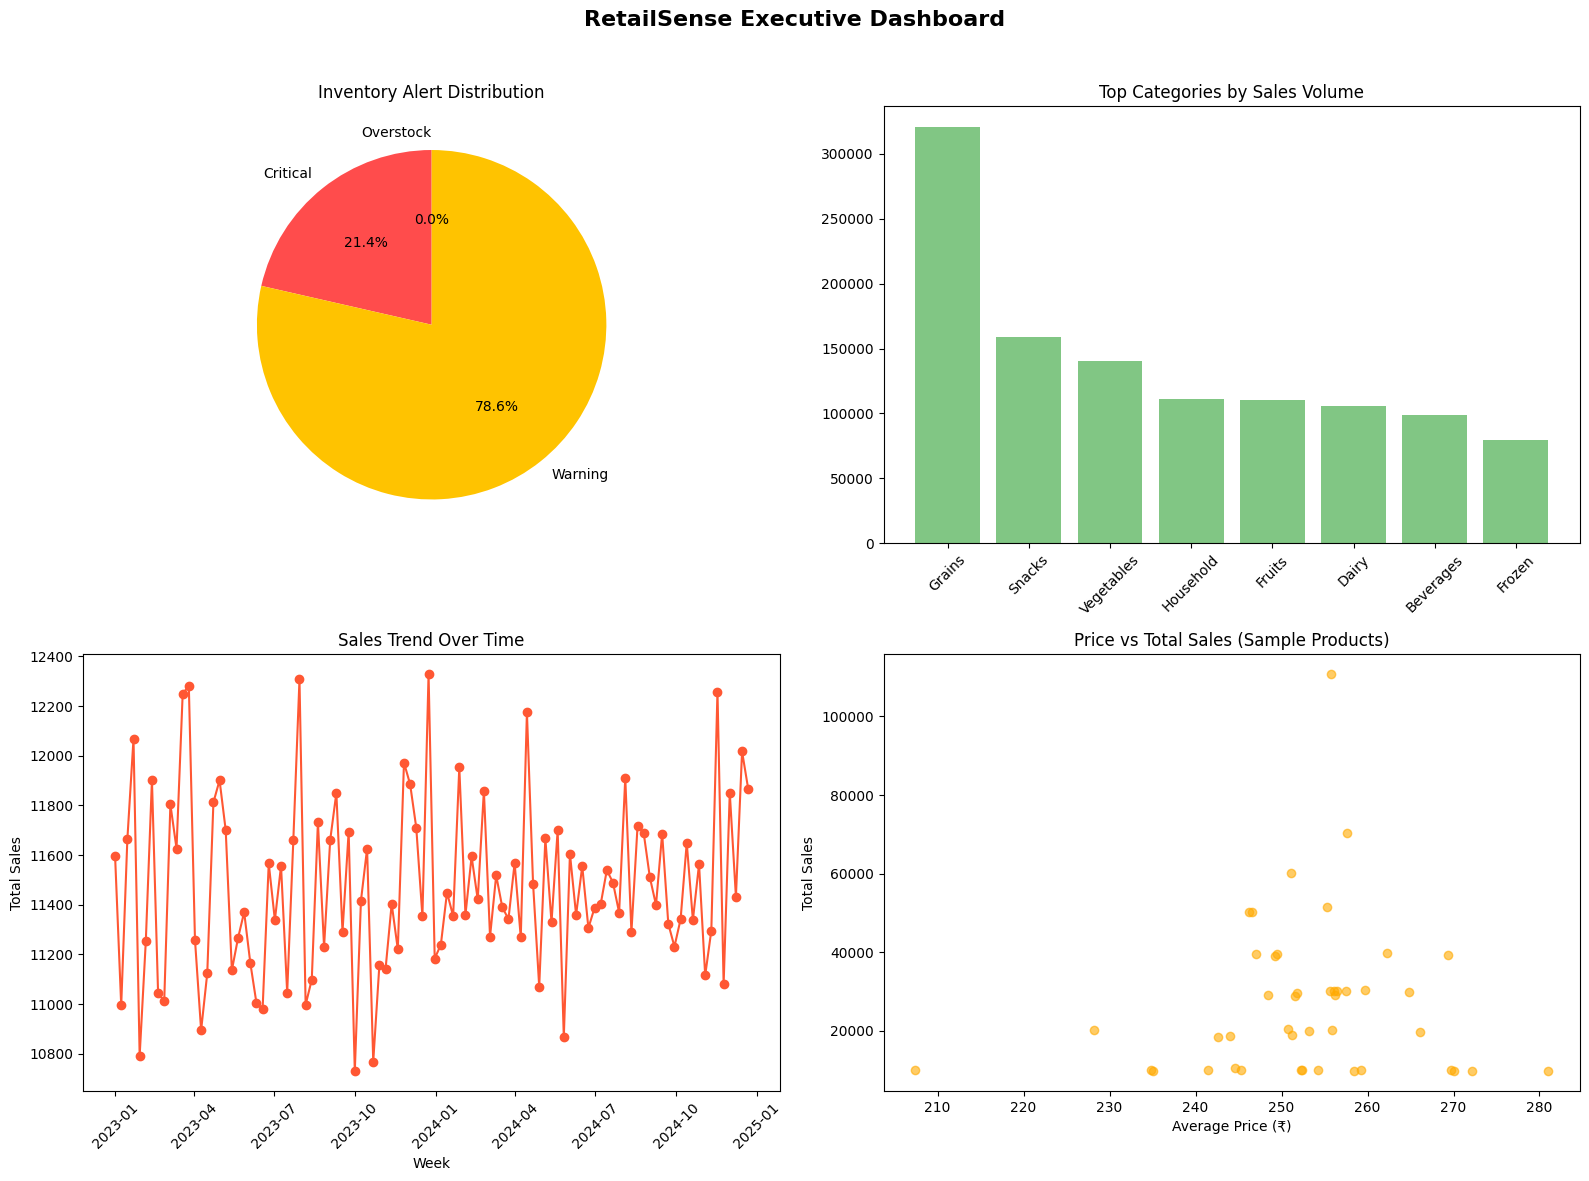

✅ Executive dashboard saved as: F:\RetailSense_Lite\outputs\executive_dashboard.png

📈 EXECUTIVE SUMMARY
🛍️  Total Products: 44
📦 Total Sales Volume: 1,193,256 units
💰 Total Revenue: ₹302,090,275.87
💵 Average Price: ₹253.42

🚨 Inventory Alerts:
   • Critical: 3
   • Warning: 11
   • Overstock: 0

📊 Key Insights:
   • Sales Anomalies Detected: 1
   • Seasonal Patterns Analyzed: 9 categories
   • Price Optimization Opportunities: 38

🎯 TOP ACTION ITEMS:
1. Restock 3 products immediately
2. Investigate 1 unusual sales patterns
3. Test price adjustment for Soft Drink


In [ ]:
# -------------------
# Cell 8: Executive Dashboard (Guarded)
# -------------------
import matplotlib.pyplot as plt

if 'SKIP_PHASE3' in globals() and SKIP_PHASE3:
    print("⏭️ Skipping executive dashboard (no uploaded data).")
else:
    def create_executive_dashboard(df, alerts, anomalies, seasonal, pricing):
        print("\n📊 STEP 8: EXECUTIVE DASHBOARD")
        print("-" * 55)
        total_products = df['product_name'].nunique()
        total_sales = df['sales_qty'].sum()
        total_revenue = (df['sales_qty'] * df['price']).sum()
        avg_price = df['price'].mean()
        critical_alerts = len([a for a in alerts if '🔴' in a['Urgency']]) if alerts else 0
        warning_alerts = len([a for a in alerts if '🟡' in a['Urgency']]) if alerts else 0
        overstock_alerts = len([a for a in alerts if '🔵' in a['Urgency']]) if alerts else 0
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('RetailSense Executive Dashboard', fontsize=16, fontweight='bold')
        alert_labels = ['Critical', 'Warning', 'Overstock']
        alert_counts = [critical_alerts, warning_alerts, overstock_alerts]
        axes[0, 0].pie(alert_counts, labels=alert_labels, autopct='%1.1f%%', startangle=90, 
                       colors=['#FF4C4C','#FFC300','#4C9AFF'])
        axes[0, 0].set_title('Inventory Alert Distribution')
        category_sales = df.groupby('category')['sales_qty'].sum().sort_values(ascending=False).head(8)
        axes[0, 1].bar(category_sales.index, category_sales.values, color='#4CAF50', alpha=0.7)
        axes[0, 1].set_title('Top Categories by Sales Volume')
        axes[0, 1].tick_params(axis='x', rotation=45)
        weekly_sales = df.groupby('week_start')['sales_qty'].sum()
        axes[1, 0].plot(weekly_sales.index, weekly_sales.values, marker='o', linestyle='-', color='#FF5733')
        axes[1, 0].set_title('Sales Trend Over Time')
        axes[1, 0].set_xlabel('Week')
        axes[1, 0].set_ylabel('Total Sales')
        axes[1, 0].tick_params(axis='x', rotation=45)
        sample_products = (
            df.groupby('product_name')
              .agg({'price':'mean', 'sales_qty':'sum'})
              .reset_index()
              .sample(min(50, len(df['product_name'].unique())))
        )
        axes[1, 1].scatter(sample_products['price'], sample_products['sales_qty'], alpha=0.6, color='#FFAA00')
        axes[1, 1].set_title('Price vs Total Sales (Sample Products)')
        axes[1, 1].set_xlabel('Average Price (₹)')
        axes[1, 1].set_ylabel('Total Sales')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        dashboard_image_path = os.path.join(OUTPUT_DIR, 'executive_dashboard.png')
        plt.savefig(dashboard_image_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✅ Executive dashboard saved as: {dashboard_image_path}")
        print("\n📈 EXECUTIVE SUMMARY")
        print(f"🛍️  Total Products: {total_products}")
        print(f"📦 Total Sales Volume: {total_sales:,} units")
        print(f"💰 Total Revenue: ₹{total_revenue:,.2f}")
        print(f"💵 Average Price: ₹{avg_price:.2f}")
        print("\n🚨 Inventory Alerts:")
        print(f"   • Critical: {critical_alerts}")
        print(f"   • Warning: {warning_alerts}")
        print(f"   • Overstock: {overstock_alerts}")
        print("\n📊 Key Insights:")
        print(f"   • Sales Anomalies Detected: {len(anomalies) if anomalies else 0}")
        print(f"   • Seasonal Patterns Analyzed: {len(seasonal) if seasonal else 0} categories")
        print(f"   • Price Optimization Opportunities: {len(pricing) if pricing else 0}")
    if df is not None:
        create_executive_dashboard(df, inventory_alerts, sales_anomalies, seasonal_insights, price_insights)
    else:
        print("❌ Data not loaded, skipping executive dashboard creation.")

In [ ]:
# -------------------
# Cell 9: Save Business Insights (Phase 3 Completion) (Guarded)
# -------------------
import os
import pandas as pd
from datetime import datetime

if 'SKIP_PHASE3' in globals() and SKIP_PHASE3:
    print("⏭️ Skipping save step (no uploaded data).")
else:
    def save_all_insights(alerts, anomalies, seasonal, pricing, output_dir=OUTPUT_DIR):
        print("\n💾 STEP 9: SAVING BUSINESS INSIGHTS")
        print("-" * 55)
        os.makedirs(output_dir, exist_ok=True)
        try:
            if alerts:
                inventory_path = os.path.join(output_dir, "business_inventory_alerts.csv")
                pd.DataFrame(alerts).to_csv(inventory_path, index=False)
                print(f"✅ Saved: {inventory_path}")
            anomalies_path = os.path.join(output_dir, "business_sales_anomalies.csv")
            pd.DataFrame(anomalies or []).to_csv(anomalies_path, index=False)
            print(f"✅ Saved: {anomalies_path}")
            if seasonal:
                seasonal_path = os.path.join(output_dir, "business_seasonal_insights.csv")
                pd.DataFrame(seasonal).to_csv(seasonal_path, index=False)
                print(f"✅ Saved: {seasonal_path}")
            if pricing:
                pricing_path = os.path.join(output_dir, "business_pricing_opportunities.csv")
                pd.DataFrame(pricing).to_csv(pricing_path, index=False)
                print(f"✅ Saved: {pricing_path}")
            summary_report = {
                "report_generated": datetime.now().isoformat(),
                "total_inventory_alerts": len(alerts or []),
                "total_sales_anomalies": len(anomalies or []),
                "seasonal_insights_generated": len(seasonal or []),
                "pricing_opportunities": len(pricing or []),
                "phase_3_complete": True,
                "ready_for_dashboard": True
            }
            report_path = os.path.join(output_dir, "phase3_completion_report.csv")
            pd.DataFrame([summary_report]).to_csv(report_path, index=False)
            print(f"✅ Saved: {report_path}")
            print(f"\n🎉 ALL INSIGHTS SAVED SUCCESSFULLY IN: {output_dir}")
        except Exception as e:
            print(f"❌ Error while saving insights: {e}")
    if df is not None:
        save_all_insights(inventory_alerts, sales_anomalies, seasonal_insights, price_insights)
    else:
        print("❌ Data not loaded, skipping save step.")


💾 STEP 9: SAVING BUSINESS INSIGHTS
-------------------------------------------------------
✅ Saved: F:\RetailSense_Lite\outputs\business_inventory_alerts.csv
✅ Saved: F:\RetailSense_Lite\outputs\business_sales_anomalies.csv
✅ Saved: F:\RetailSense_Lite\outputs\business_seasonal_insights.csv
✅ Saved: F:\RetailSense_Lite\outputs\business_pricing_opportunities.csv
✅ Saved: F:\RetailSense_Lite\outputs\phase3_completion_report.csv

🎉 ALL INSIGHTS SAVED SUCCESSFULLY IN: F:\RetailSense_Lite\outputs


In [ ]:
# -------------------
# Cell 10: Phase 3 Completion Summary (Guarded)
# -------------------
import os
from datetime import datetime

if 'SKIP_PHASE3' in globals() and SKIP_PHASE3:
    print("⏭️ Skipping Phase 3 summary (no uploaded data).")
else:
    def phase3_completion_summary(df, alerts, anomalies, seasonal, pricing, output_dir=OUTPUT_DIR):
        print("\n" + "="*70)
        print("🎯 PHASE 3: BUSINESS LAYER & INSIGHTS COMPLETED!")
        print("="*70)
        print(f"📅 Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        if df is not None:
            print(f"\n✅ DELIVERABLES GENERATED (saved in '{output_dir}'):")
            print(f"   📊 Executive Dashboard: {os.path.join(output_dir, 'executive_dashboard.png')}")
            print(f"   📋 Inventory Alerts: {os.path.join(output_dir, 'business_inventory_alerts.csv')}")
            print(f"   🚨 Sales Anomalies: {os.path.join(output_dir, 'business_sales_anomalies.csv')}")
            print(f"   📅 Seasonal Insights: {os.path.join(output_dir, 'business_seasonal_insights.csv')}")
            print(f"   💰 Pricing Opportunities: {os.path.join(output_dir, 'business_pricing_opportunities.csv')}")
            print(f"   📄 Completion Report: {os.path.join(output_dir, 'phase3_completion_report.csv')}")
            print(f"\n🚀 NEXT STEPS:")
            print(f"   → Phase 4: Build interactive Streamlit dashboard")
            print(f"   → Phase 5: Deploy to cloud platform")
            print(f"   → Phase 6: Add innovation features")
            print(f"\n💡 KEY INSIGHTS GENERATED:")
            print(f"   • {len(alerts or [])} inventory recommendations")
            if anomalies and len(anomalies) == 1 and isinstance(anomalies[0], dict) and anomalies[0].get("type") == "NONE":
                print(f"   • No anomalies detected")
            else:
                print(f"   • {len(anomalies or [])} anomalies investigated")
            print(f"   • {len(seasonal or [])} seasonal patterns identified")
            print(f"   • {len(pricing or [])} pricing opportunities found")
        else:
            print("❌ Phase 3 could not complete due to data loading issues")
            print("💡 Please ensure Phase 2 was completed successfully")
        print("="*70)
    if df is not None:
        phase3_completion_summary(df, inventory_alerts, sales_anomalies, seasonal_insights, price_insights)


🎯 PHASE 3: BUSINESS LAYER & INSIGHTS COMPLETED!
📅 Completed: 2025-09-11 23:18:04

✅ DELIVERABLES GENERATED (saved in 'F:\RetailSense_Lite\outputs'):
   📊 Executive Dashboard: F:\RetailSense_Lite\outputs\executive_dashboard.png
   📋 Inventory Alerts: F:\RetailSense_Lite\outputs\business_inventory_alerts.csv
   🚨 Sales Anomalies: F:\RetailSense_Lite\outputs\business_sales_anomalies.csv
   📅 Seasonal Insights: F:\RetailSense_Lite\outputs\business_seasonal_insights.csv
   💰 Pricing Opportunities: F:\RetailSense_Lite\outputs\business_pricing_opportunities.csv
   📄 Completion Report: F:\RetailSense_Lite\outputs\phase3_completion_report.csv

🚀 NEXT STEPS:
   → Phase 4: Build interactive Streamlit dashboard
   → Phase 5: Deploy to cloud platform
   → Phase 6: Add innovation features

💡 KEY INSIGHTS GENERATED:
   • 14 inventory recommendations
   • 1 anomalies investigated
   • 9 seasonal patterns identified
   • 38 pricing opportunities found
